In [25]:
from main import *

from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
NOTEBOOK_ID = '13'
RUN_MODELS = False

In [26]:
initial_dataset = pd.read_csv(f'{TARGET_DIR}/01-dataset/hummel_preprocessed_Activity_500k_Rat.csv')[['AAseq','Activity_500k_Rat']].rename(columns={'Activity_500k_Rat':'old_activity'})
initial_scaler = preprocessing.MinMaxScaler()
initial_dataset['old_activity_scaled'] = initial_scaler.fit_transform(initial_dataset['old_activity'].to_numpy().reshape(-1,1))
initial_dataset['dataset'] = 'Hummel'

hummel_test_df = pd.read_csv(f'{LIBRARY_DIR}/hummel_test.csv')[['aa_seq','activity','prediction','uncertainty']].rename(columns={'aa_seq':'AAseq','activity':'old_activity_standardscaled'})
initial_dataset['is_test'] = initial_dataset['AAseq'].isin(hummel_test_df['AAseq'])

new_dataset = pd.read_csv(f'{HARMONIZE_DIR}/04-results/active_learning_activity.csv')
new_dataset = new_dataset[['dataset','DNAseq','Activity']]
new_dataset = (new_dataset
           .query('dataset == "sort_2" or dataset == "sort_2_noPCR1"')
           .groupby(['DNAseq'])['Activity']
           .mean()
           .reset_index()
           .dropna()
           .reset_index(drop=True)
           .rename(columns={'Activity':'new_activity'})
           )
new_dataset['AAseq'] = new_dataset['DNAseq'].apply(lambda x: str(Seq(x).translate()))
new_scaler = preprocessing.MinMaxScaler()
new_dataset['new_activity_scaled'] = new_scaler.fit_transform(new_dataset['new_activity'].to_numpy().reshape(-1,1))
new_dataset['dataset'] = 'Mycocosm'

overlap_df = new_dataset.merge(initial_dataset,on='AAseq')[['DNAseq','AAseq','old_activity','new_activity','old_activity_scaled','new_activity_scaled']]

# identify linear range

In [27]:
max_dict = {}
for max_activity in list(range(260_000, 240_000-1, -100)):
    tmp_df = overlap_df.copy()
    tmp_df = tmp_df.query(f'new_activity < {max_activity}')
    max_dict[max_activity] = pearsonr(tmp_df['new_activity'],tmp_df['old_activity'])[0]
tmp_df = pd.DataFrame([max_dict]).T
activity_max = tmp_df.idxmax().max() # max Pearson r at 248_000

min_dict = {}
for min_activity in list(range(0, 100_000, 100)):
    tmp_df = overlap_df.copy()
    tmp_df = tmp_df.query(f'new_activity > {min_activity}')
    min_dict[min_activity] = pearsonr(tmp_df['new_activity'],tmp_df['old_activity'])[0]
tmp_df = pd.DataFrame([min_dict]).T
activity_min = tmp_df.idxmax().min() # max Pearson r at 19_000

print(activity_min,activity_max)
filtered_df = overlap_df.copy()
filtered_df = filtered_df.query(f'new_activity > {activity_min} and new_activity < {activity_max}')
print('number of tiles pass filter from new dataset', len(new_dataset.query(f'new_activity > {activity_min} and new_activity < {activity_max}')['AAseq'].unique()))
print('number of tiles failed filter from new dataset', len(new_dataset.query(f'new_activity <= {activity_min} or new_activity >= {activity_max}')['AAseq'].unique()))

18900 248300
number of tiles pass filter from new dataset 6621
number of tiles failed filter from new dataset 1910


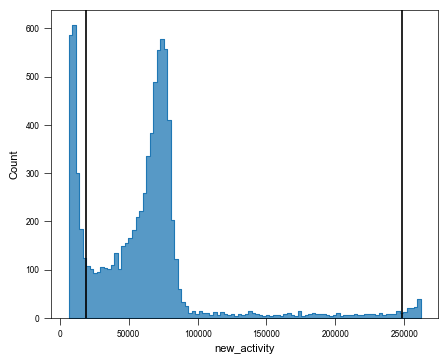

In [28]:
fig = plt.figure(figsize=(5,4))
g = sns.histplot(data=new_dataset,x='new_activity',element='step',bins=100)
g.axvline(x=activity_min,ymin=0.0,ymax=1.0,color='black')
g.axvline(x=activity_max,ymin=0.0,ymax=1.0,color='black')

# harmonize new to old distribution

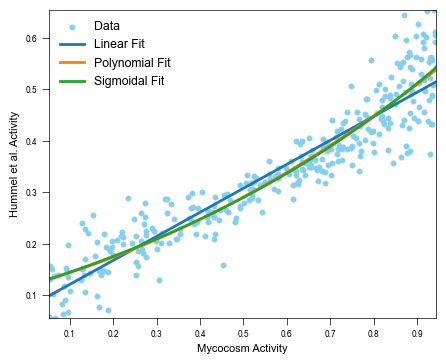

In [29]:
x_data = filtered_df['new_activity_scaled'].to_numpy().flatten()
y_data = filtered_df['old_activity_scaled'].to_numpy().flatten()
X_new = np.linspace(x_data.min(), x_data.max(), 100)

p0 = [max(y_data), np.median(x_data), 1, min(y_data)] 
sig_popt, pcov = curve_fit(sigmoid, x_data, y_data, p0, maxfev=10000)
y_pred_sig = sigmoid(X_new, *sig_popt)

p0 = [1, 0]
lin_popt, pcov = curve_fit(linear, x_data, y_data, p0, maxfev=10000)
y_pred_lin = linear(X_new, *lin_popt)

p0 = [1, 0, 0] 
poly_popt, pcov = curve_fit(polynomial, x_data, y_data, p0, maxfev=10000)
y_pred_poly = polynomial(X_new, *poly_popt)
tab10 = sns.color_palette('tab10')

plt.figure(figsize=(5,4))
g = sns.scatterplot(x=x_data,y=y_data,label='Data',s=15,edgecolor=None,color='skyblue')
g = sns.lineplot(x=X_new,y=y_pred_lin,label='Linear Fit',color=tab10[0],linewidth=2)
g = sns.lineplot(x=X_new,y=y_pred_poly,label='Polynomial Fit',color=tab10[1],linewidth=2)
g = sns.lineplot(x=X_new,y=y_pred_sig,label='Sigmoidal Fit',color=tab10[2],linewidth=2)

g.set(xlabel='Mycocosm Activity',ylabel='Hummel et al. Activity')
g.set_xlim(x_data.min(),x_data.max())
g.set_ylim(y_data.min(),y_data.max())
g.legend(frameon=False)

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-harmonize_overlap_scatterplot_minmax.png',dpi=400,transparent=False,bbox_inches='tight')

In [30]:
sanborn_test_df = pd.read_csv(f'{LIBRARY_DIR}/sanborn_test.csv')
sanborn_test_df = new_dataset.merge(sanborn_test_df,left_on='AAseq',right_on='protein sequence')
sanborn_test_df['is_filtered'] = sanborn_test_df['new_activity_scaled'].apply(lambda x: x >= filtered_df['new_activity_scaled'].min() and x <= filtered_df['new_activity_scaled'].max() )

out_file = f'{HARMONIZE_DIR}/04-results/old_to_new_harmonized_dataset.csv'
if not os.path.isfile(out_file):
    linear_df = harmonize_dataset(initial_dataset,new_dataset,linear,lin_popt,harmonized_col_prefix='linear_')
    polynomial_df = harmonize_dataset(initial_dataset,new_dataset,polynomial,poly_popt,harmonized_col_prefix='polynomial_')[['polynomial_harmonized_activity_scaled','polynomial_harmonized_activity']]
    sigmoid_df = harmonize_dataset(initial_dataset,new_dataset,sigmoid,sig_popt,harmonized_col_prefix='sigmoid_')[['sigmoid_harmonized_activity_scaled','sigmoid_harmonized_activity']]
    harmonized_df = pd.concat([linear_df,polynomial_df,sigmoid_df],axis=1)
    # harmonized_df = harmonized_df.drop(columns=['new_activity','new_activity_scaled','old_activity','old_activity_scaled'])
    harmonized_df.to_csv(out_file,index=False)
else:
    harmonized_df = pd.read_csv(out_file)

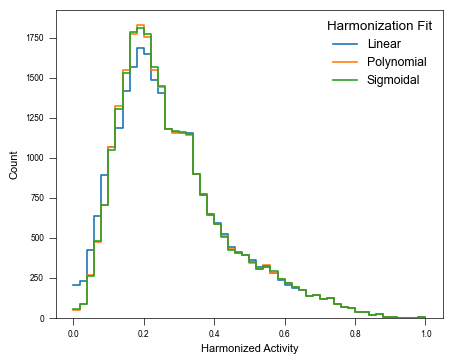

In [31]:
plt.figure(figsize=(5,4))
g = sns.histplot(data=harmonized_df,x='linear_harmonized_activity_scaled',element='step',bins=50,hue_order=['Mycocosm','Hummel','Overlap'],fill=False,label='Linear')
g = sns.histplot(data=harmonized_df,x='polynomial_harmonized_activity_scaled',element='step',bins=50,hue_order=['Mycocosm','Hummel','Overlap'],fill=False,label='Polynomial')
g = sns.histplot(data=harmonized_df,x='sigmoid_harmonized_activity_scaled',element='step',bins=50,hue_order=['Mycocosm','Hummel','Overlap'],fill=False,label='Sigmoidal')
g.set(xlabel='Harmonized Activity')
g.legend(frameon=False,title='Harmonization Fit')

[Text(0.5, 0, 'Hummel et al. Activity'), Text(0, 0.5, 'Harmonized Activity')]

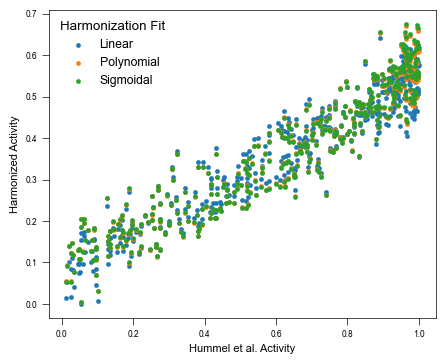

In [32]:
plt.figure(figsize=(5,4))
test_df = harmonized_df.query('dataset == "Mycocosm_Overlap"').drop(columns=['old_activity','old_activity_scaled']).merge(initial_dataset.query('is_test == True').drop(columns=['dataset','is_test']),on='AAseq')
g = sns.scatterplot(data=test_df,x='new_activity_scaled',y='linear_harmonized_activity_scaled',s=10,edgecolor=None,label='Linear')
g = sns.scatterplot(data=test_df,x='new_activity_scaled',y='polynomial_harmonized_activity_scaled',s=10,edgecolor=None,label='Polynomial')
g = sns.scatterplot(data=test_df,x='new_activity_scaled',y='sigmoid_harmonized_activity_scaled',s=10,edgecolor=None,label='Sigmoidal')
g.legend(frameon=False,title='Harmonization Fit')
g.set(xlabel='Hummel et al. Activity',ylabel='Harmonized Activity')

In [33]:
harmonized_df.query('dataset != "Mycocosm_Overlap"').reset_index(drop=True).to_csv(f'{HARMONIZE_DIR}/04-results/new_to_old_harmonized_dataset.csv',index=False)
tmp_df = test_df.copy()
tmp_df = tmp_df.query('linear_harmonized_activity_scaled > 0.0 and linear_harmonized_activity_scaled < 1.0')
tmp_df = tmp_df.query('polynomial_harmonized_activity_scaled > 0.0 and polynomial_harmonized_activity_scaled < 1.0')
tmp_df = tmp_df.query('sigmoid_harmonized_activity_scaled > 0.0 and sigmoid_harmonized_activity_scaled < 1.0')

print('Spearman r:',
    spearmanr(tmp_df['old_activity_scaled'],tmp_df['linear_harmonized_activity_scaled'])[0],
    spearmanr(tmp_df['old_activity_scaled'],tmp_df['polynomial_harmonized_activity_scaled'])[0],
    spearmanr(tmp_df['old_activity_scaled'],tmp_df['sigmoid_harmonized_activity_scaled'])[0],
)
print('Pearsonr r:',
    pearsonr(tmp_df['old_activity_scaled'],tmp_df['linear_harmonized_activity_scaled'])[0],
    pearsonr(tmp_df['old_activity_scaled'],tmp_df['polynomial_harmonized_activity_scaled'])[0],
    pearsonr(tmp_df['old_activity_scaled'],tmp_df['sigmoid_harmonized_activity_scaled'])[0],
)

Spearman r: 0.8912745559632111 0.903397024888357 0.9049905577306754
Pearsonr r: 0.8439032380019574 0.8665027274364485 0.8696559795045282


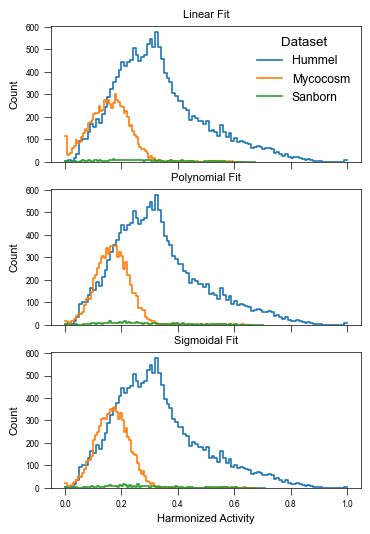

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4,6),sharex=True)
g = sns.histplot(data=harmonized_df.query('dataset == "Hummel"'),x='linear_harmonized_activity_scaled',element='step',bins=100,label='Hummel',fill=False,ax=axes[0])
sns.histplot(data=harmonized_df.query('dataset == "Mycocosm"'),x='linear_harmonized_activity_scaled',element='step',bins=100,label='Mycocosm',fill=False,ax=axes[0])
sns.histplot(data=harmonized_df.query('dataset == "Sanborn"'),x='linear_harmonized_activity_scaled',element='step',bins=100,label='Sanborn',fill=False,ax=axes[0])
# sns.histplot(data=harmonized_df.query('dataset == "Overlap"'),x='linear_harmonized_activity_scaled',element='step',bins=100,label='Harmonization',fill=False,ax=axes[0])
g.set(title='Linear Fit')
g.legend(title='Dataset',frameon=False)

g = sns.histplot(data=harmonized_df.query('dataset == "Hummel"'),x='polynomial_harmonized_activity_scaled',element='step',bins=100,label='Hummel',fill=False,ax=axes[1])
sns.histplot(data=harmonized_df.query('dataset == "Mycocosm"'),x='polynomial_harmonized_activity_scaled',element='step',bins=100,label='Mycocosm',fill=False,ax=axes[1])
sns.histplot(data=harmonized_df.query('dataset == "Sanborn"'),x='polynomial_harmonized_activity_scaled',element='step',bins=100,label='Sanborn',fill=False,ax=axes[1])
# sns.histplot(data=harmonized_df.query('dataset == "Overlap"'),x='polynomial_harmonized_activity_scaled',element='step',bins=100,label='Overlap',fill=False,ax=axes[1])
g.set(title='Polynomial Fit')

g = sns.histplot(data=harmonized_df.query('dataset == "Hummel"'),x='sigmoid_harmonized_activity_scaled',element='step',bins=100,label='Hummel',fill=False,ax=axes[2])
sns.histplot(data=harmonized_df.query('dataset == "Mycocosm"'),x='sigmoid_harmonized_activity_scaled',element='step',bins=100,label='Mycocosm',fill=False,ax=axes[2])
sns.histplot(data=harmonized_df.query('dataset == "Sanborn"'),x='sigmoid_harmonized_activity_scaled',element='step',bins=100,label='Sanborn',fill=False,ax=axes[2])
# sns.histplot(data=harmonized_df.query('dataset == "Overlap"'),x='sigmoid_harmonized_activity_scaled',element='step',bins=100,label='Overlap',fill=False,ax=axes[2])
g.set(xlabel='Harmonized Activity',title='Sigmoidal Fit')

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-histplot_harmonized_dataset.png',dpi=400,transparent=False,bbox_inches='tight')

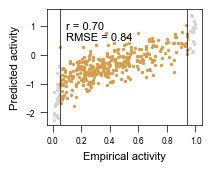

In [35]:
fig = plt.figure(figsize=(2,1.5))
g = sns.scatterplot(data=sanborn_test_df.query('is_filtered == False'),x='new_activity_scaled',y='predictions',s=5,edgecolor=None,color='lightgrey')
g = sns.scatterplot(data=sanborn_test_df.query('is_filtered == True'),x='new_activity_scaled',y='predictions',s=5,edgecolor=None,color='#d89b47')
g.axvline(x=filtered_df['new_activity_scaled'].min(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
g.axvline(x=filtered_df['new_activity_scaled'].max(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
r = pearsonr(sanborn_test_df.query('is_filtered == True')['new_activity_scaled'],sanborn_test_df.query('is_filtered == True')['predictions'])[0]
rmse = mean_squared_error(sanborn_test_df.query('is_filtered == True')['new_activity_scaled'],sanborn_test_df.query('is_filtered == True')['predictions'],squared=False)
g.text(x=0.125,y=0.90,ha='left',va='top',s=f"r = {r:.2f}\nRMSE = {rmse:.2f}",transform=g.transAxes)
g.set(ylabel='Predicted activity',xlabel='Empirical activity')
g.xaxis.set_tick_params(width=0.5)
g.yaxis.set_tick_params(width=0.5)
for axis in ['top','bottom','left','right']:
    g.spines[axis].set_linewidth(0.5)

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-control_figure.svg',transparent=True,bbox_inches='tight')

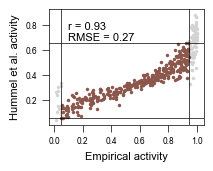

In [36]:
fig = plt.figure(figsize=(2,1.5))
g = sns.scatterplot(data=overlap_df,x='new_activity_scaled',y='old_activity_scaled',s=5,color='lightgrey',edgecolor=None)
sns.scatterplot(data=filtered_df,x='new_activity_scaled',y='old_activity_scaled',s=5,color=COLORS[10],edgecolor=None)
g.axvline(x=filtered_df['new_activity_scaled'].min(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
g.axvline(x=filtered_df['new_activity_scaled'].max(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
g.axhline(y=filtered_df['old_activity_scaled'].min(),xmin=0.0,xmax=1.0,color='black',linewidth=0.5)
g.axhline(y=filtered_df['old_activity_scaled'].max(),xmin=0.0,xmax=1.0,color='black',linewidth=0.5)
r = pearsonr(filtered_df['old_activity_scaled'],filtered_df['new_activity_scaled'])[0]
rmse = mean_squared_error(filtered_df['old_activity_scaled'],filtered_df['new_activity_scaled'],squared=False)
g.text(x=0.125,y=0.90,ha='left',va='top',s=f"r = {r:.2f}\nRMSE = {rmse:.2f}",transform=g.transAxes)
g.set(xlabel='Empirical activity',ylabel='Hummel et al. activity')
# sns.lineplot(x=X_new,y=y_pred_lin,label='Linear Fit',color='skyblue',linewidth=2)
# g.legend(frameon=False,fontsize=8,bbox_to_anchor=(0.90, 0.95))
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-harmonized_figure.svg',transparent=True,bbox_inches='tight')

In [37]:
fig = plt.figure(figsize=(3.5,2))

g = sns.scatterplot(data=mycocosm_df.query('is_filtered == False'),x='new_activity_scaled',y='predictions',s=3,edgecolor=None,color='lightgrey')
g = sns.scatterplot(data=mycocosm_df.query('is_filtered == True'),x='new_activity_scaled',y='predictions',s=3,edgecolor=None,color='#69764d')
g.axvline(x=filtered_df['new_activity_scaled'].min(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
g.axvline(x=filtered_df['new_activity_scaled'].max(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
r = pearsonr(mycocosm_df.query('is_filtered == True')['new_activity_scaled'],mycocosm_df.query('is_filtered == True')['predictions'])[0]
rmse = mean_squared_error(mycocosm_df.query('is_filtered == True')['new_activity_scaled'],mycocosm_df.query('is_filtered == True')['predictions'],squared=False)
g.text(x=0.85,y=0.125,ha='right',va='bottom',s=f"r = {r:.2f}\nRMSE = {rmse:.2f}",transform=g.transAxes)
g.set(ylabel='Predicted Activity (AU)',xlabel='Experimental Activity (AU)')
g.xaxis.set_tick_params(width=0.5)
g.yaxis.set_tick_params(width=0.5)
for axis in ['top','bottom','left','right']:
    g.spines[axis].set_linewidth(0.5)
    
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-test_figure.svg',transparent=True,bbox_inches='tight')

NameError: name 'mycocosm_df' is not defined

<Figure size 350x200 with 0 Axes>

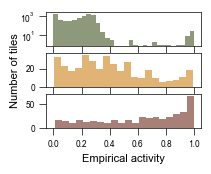

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(2,1.5),sharex=True)

g = sns.histplot(data=harmonized_df.query('dataset == "Mycocosm"'),x='new_activity_scaled',element='step',bins=30,label='Test tiles',color='#69764d',edgecolor=None,ax=axes[0])
g.set(xlabel=None,ylabel=None,yscale='log')
g = sns.histplot(data=harmonized_df.query('dataset == "Sanborn"'),x='new_activity_scaled',element='step',bins=20,label='Control tiles',color='#d89b47',edgecolor=None,ax=axes[1])
g.set(xlabel=None,ylabel='Number of tiles')
g = sns.histplot(data=harmonized_df.query('dataset == "Mycocosm_Overlap"'),x='new_activity_scaled',element='step',bins=20,label='Harmonization tiles',color=COLORS[10],edgecolor=None,ax=axes[2])
g.set(xlabel='Empirical activity',ylabel=None)
g.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2))


plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-harmonized_histogram.svg',transparent=True,bbox_inches='tight')

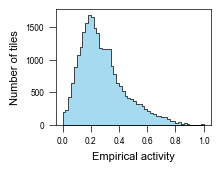

In [42]:
fig = plt.figure(figsize=(2,1.5))
g = sns.histplot(data=harmonized_df,x='linear_harmonized_activity_scaled',element='step',bins=50,color='skyblue',edgecolor='black',linewidth=0.5)

g.set(xlabel='Empirical activity',ylabel='Number of tiles')
g.xaxis.set_tick_params(width=0.5)
g.yaxis.set_tick_params(width=0.5)
for axis in ['top','bottom','left','right']:
    g.spines[axis].set_linewidth(0.5)
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-harmonized_histogram.png',**FIGURE_PARAMS)
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-harmonized_histogram.svg',**FIGURE_PARAMS)

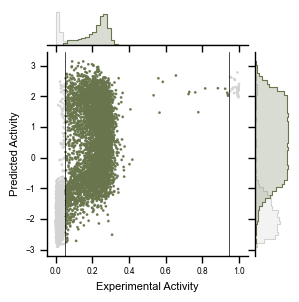

In [ ]:
g = sns.JointGrid(data=mycocosm_df,y='predictions',x='new_activity_scaled',hue='is_filtered',height=3,hue_order=[True,False])
g.plot_joint(sns.scatterplot,s=3,edgecolor=None,palette=['#69764d','lightgrey'],legend=False)
g.plot_marginals(sns.histplot,fill=True,palette=['#69764d','lightgrey'],element='step',bins=50)
g.ax_joint.set(ylabel='Predicted Activity',xlabel='Experimental Activity')
g.ax_joint.axvline(x=filtered_df['new_activity_scaled'].min(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)
g.ax_joint.axvline(x=filtered_df['new_activity_scaled'].max(),ymin=0.0,ymax=1.0,color='black',linewidth=0.5)